# Introduction

The objective of this notebook is to explain the transformer architecture and implement it from scratch using lower-level TensorFlow APIs. This notebook is divided in three sections for the task at hand.

The first section is for the exploring the implemention of the transformer architecture. The implementations in this notebook follows that provided in the official TensorFlow website. 

The second section is exploring the prepared dataset which we'll use in training the transformer model for the purpose of translating French text inputs to English and vice versa. We'll have to build different models for this purpose so we'll have a different notebook for training the model to translate in the other way. In this notebook, we'll translate ```French to English``` sentences. 

The third section will explore creating a wrapper function that can be easily queried for offline translating of inputs to the other language. We will also explore rewriting the Transformer architecture using only Keras Functional/Sequential APIs. Also, a lang-detect API will be used for the offline use of the model. The goal is for the lang-detect API to know when the user provides English sentences and then use the wrapper function provide the required model to translate to French (and the other way around). 

# 1. The Transformer Architecture

![The Transformer](https://miro.medium.com/max/700/1*BHzGVskWGS_3jEcYYi6miQ.png)


After the revolution of the research paper from scientists at Google in 2017, [Attention is all you need](https://arxiv.org/abs/1706.03762), the field of Natural Language Processing (and even Computer Vision) exploded with the new architecture proposed. The Transformer is special because it dealt away with recurrence in its architecture and focused solely on attention mechanisms. 

RNNs, recurrent neural networks, was the start-of-the-art architecture in the field of Natural Language Processing. RNNs work well with tasks like sentiment analysis or topic modelling. In order to use RNNs for sequence-sequence tasks like translation, summarization or text generation, the model had to be designed in such a way that one section would be for the encoder (the goal of which is to create a rich representation of the text input) and the other section would be for the decoder (which would receive outputs from the encoder and use it to output tokens for the task at hand). The encoders and decoders are usually similarly designed with the decoder usually having some sort of mask so that future tokens are not seen (otherwise its predictions would be trivial). 

The problem with RNNs is that they're quite slow and can't really handle long sequences. Improvements to the RNNs is the use of attention mechanisms. With the paper from the Google scientists, the Transformer dealt away with recurrence altogether and used only attention mechanisms for its architecture. It uses self-attention to detect subtle ways even distant data elememts in a sequence influence and depend on each other. 

Popular Transformers in use in the current ML landscape include encoder only, decoder only and also encoder-decoder models. Encoder only models like BERT (Bidirectional Encoder Representations from Transformers) and its variants like RoBERTa, DistilBERT etc convert an input sequence of text into a rich numerical representation. This makes it quite useful in tasks like text classification or named-entity recognition where BERT, for example, is used as a base pretrained model to finetune for the task at hand. 

Decoder only models like the family of GPT (Generative Predictive Transformers) will autocomplete the sequence by iteratively predicting the most probable next word. This makes them quite useful in tasks like code completion, sentence generation, summarization and so on. Examples of common Decoder only models are GPT-3 and T5.

An encoder-decoder transformer models complext mappings from one sequence of text to another suitable for tasks like summarization and translation. 

![](https://www.tensorflow.org/images/tutorials/transformer/standard_transformer_architecture.png)

Let's offer a high-level explanation of the transformer architecture here block by block:

The Transformer starts by generating initial representations, or embeddings, for each word... Then, using self-attention, it aggregates information from all of the other words, generating a new representation per word informed by the entire context. This step is then repeated multiple times in parallel for all words, successively generating new representations.

a. The Transformer consists of two arms - the Encoder and Decoder. The Encoder generates a rich vector representation of the input while the decoder predicts the next token based on the tokens it's being fed. The transformer architecture can be used for sequence-sequence tasks like translation.

b. The input to the Encoder is the word vectors obtained after tokenizing, vectorizing and padding the sequences from the text input. The start_of_sequence and end_of_sequence tokens needs to be added at the start and end of each text input. 

c. A dense vector embeddings of the input text is created. Positional encodings are added to the embeddings and this is fed to several attention heads. Layer normalization and skip connections are involved with this process so as to ensure smooth gradients for backpropagation.

d. The Encoder has N encoder sublayers and the output of one is passed to the next and the output at the top encoder is passed to the decoder.

e. The decoder has almost the exact architecture as the decoder but it computes a second type of attention - ensuring that future predictions only take the current and past tokens into considerations. This is done via masking as implemented in the previous section.

f. The output of the top decoder is passed through a final Dense layer and a softmax layer to output probabilities at each position step. At each step of prediction, the decoder uses only the current and past tokens, and the token with the highest probability at that stage is the output which is further being decoded to have it in text.

### Set up Environment

In [1]:
# let's import all necessary dependencies

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import gc
import tensorflow as tf
from tensorflow import keras
from keras import models, layers
from tensorflow.python.ops.numpy_ops import np_config

import warnings
warnings.filterwarnings('ignore')

np_config.enable_numpy_behavior()

We need to take advantage of Kaggle's new multi-GPU use with the T4-x2 GPU. Following the steps from this [notebook](https://www.kaggle.com/code/peremartramanonellas/using-multiple-gpu-s-with-tensorflow-on-kaggle) explains how to set it up. 

Documentation for [tf.distribute](https://www.tensorflow.org/api_docs/python/tf/distribute)

In [2]:
# Define and get the number os devices. 
#strategy = tf.distribute.MirroredStrategy()
#print('DEVICES AVAILABLE: {}'.format(strategy.num_replicas_in_sync))

## Implementing the Transformer

### Positional Encoding

As seen in the transformer block diagram above, the vector input to the transformer is embedded and then positional encodings are added. Since this model doesn't contain any recurrence or convolution, positional encoding is added to give the model some information about the relative position of the words in the sentence. 

The position encoding function is a stack of sines and cosines that vibrate at different frequencies depending of their location along the depth of the emvedding vector. They vibrate across the position axis.

Embeddings represent a token in a d-dimensional space where tokens with similar meaning will be closer to each other. But the embeddings do not encode the relative position of words in a sentence. So after adding the positional encoding, words will be closer to each other based on the *similarity of their meaning and their position in the sentence*, in the d-dimensional space.

The formula for calculating the positional encoding is as follows:

$$\Large{PE_{(pos, 2i)} = sin(pos / 10000^{2i / d_{model}})} $$
$$\Large{PE_{(pos, 2i+1)} = cos(pos / 10000^{2i / d_{model}})} $$

In [3]:
def get_angles(pos, i, d_model):
    """
    Function to compute the angles for positional encoding.
    
    Returns the angle computed
    """
    angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
    return pos * angle_rates

In [4]:
def positional_encoding(position, d_model):
    """
    Adds  positional encoding to the Embeddings to be fed to the Transformer model.
    
    Computes a sin and cos of the angles determined by the get_angles() function
    and adds the value computed to an axis of the embeddings.
    """
    angle_rads = get_angles(np.arange(position)[:, np.newaxis], 
                           np.arange(d_model)[np.newaxis, :], d_model)
    
    # apply sin to even indices in the array. ie 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    
    # apply cos to odd indices in the array. ie 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    
    pos_encoding = angle_rads[np.newaxis, ...]
    return tf.cast(pos_encoding, dtype=tf.float32)

### Attention

![](https://e2eml.school/images/transformers/architecture_single_head.png)

The primary concept of the Transformers is the self-attention or intra-attention mechanism. The self in self-attention refers to the fact that the attention weights are computed for all hidden states in the same set - for example, all the hidden states of the encoder. As the transformer model processes each word, self-attention allows it to look at other positions in the input sequences for clues that can help it lead to a better encoding for the particular word (or token).

The equation used to calculate the attention weights is:

$$\Large{Attention(Q, K, V) = softmax_k\left(\frac{QK^T}{\sqrt{d_k}}\right) V} $$

The main idea behind attention is that instead of producing a single hidden state for the input sequence, the encoder outputs a hidden state at each step that the decoder can access. However, using all the states at the same time would create a huge input for the decoder. This is where attention comes in - it lets the decoder assign a different amount of weight or attention to each of the encoder states at every decoding timestep.

Steps:

a. Create three vectors from each of the encoder's input vectors(embeddings of each word). The dimension of the input embeddings is given as d_model in the paper and they used an embedding size of 512. For each attention unit the transformer model learns three weight matrices; the query weights, the key weights, and the value weights. For each token, the input word embedding is multiplied with each of the three weight matrices to produce a query vector Q((vector representation of one word in the sequence), a key vector K (vector representations of all the words in the sequence), and a value vector V(which are the vector representations of all the words in the sequence).

The query Q represents the feature of interest and the matrix K represents the collection of masks. Because it's stored with masks in columns, rather than rows, it needs to be transposed (with the T operator) before multiplying. The vectors q, k, v are smaller in dimension than the embedding vector. The reason for this will be explained soon.

b. Calculate a score: The attention score is calculated by taking the dot product of the query vector and the key vector of the respective word we're scoring. For a sequence of n inputs, we'd have a corresponding n x n matrix of attention scores.

c. Scaling: The attention scores are divided by √dk (dimension of the key vector or depth). This dimension is equal to 64 in the paper, so the matrix of attention scores is scaled by 1/8. This is done because for large values of depth, the dot product grows large in magnitude pushing the softmax function where it has small gradients resulting in a very hard softmax. For example, consider that Q and K have a mean of 0 and variance of 1. Their matrix multiplication will have a mean of 0 and variance of dk. So the square root of dk is used for scaling, so you get a consistent variance regardless of the value of dk. If the variance is too low the output may be too flat to optimize effectively. If the variance is too high the softmax may saturate at initialization making it difficult to learn

d. Normalized: The attention scores in the matrix are normalized so that they add up to 1. This is done with the softmax function. The matrix obtained after this step is known as the attention weights.

e. Multiply the value vector V for each word by the attention weights and then sum up to produce the output of the self-attention lyer for that position. It is probably helpful to think of the attention weights as where to look and the Value vector as what one wants to actually get. 

In [5]:
def scaled_dot_product_attention(q, k, v, mask):
    """
    Computes the attention weight for the q, k, v vectors
    
    Attention in the transformer is popularly known as self-attention because the q, k, v vectors are
    sourced from the same sequence. Self Attention, also called intra Attention, is an attention mechanism relating 
    different positions of a single sequence in order to compute a representation of the same sequence.
    
    q, k, v must have leading dimensions - same 'batch_size'
    k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v
    
    q - query vectors; shape == (..., seq_len_q, depth)
    k - key vectors; shape == (..., seq_len_k, depth)
    v - value vectors; shape == (..., seq_len_v, depth_v)
    
    Returns - attention weights, output
    """
    matmul_qk = tf.matmul(q, k, transpose_b = True)
    dk = tf.cast(tf.shape(k)[-1], dtype=tf.float32)
    scaled_dk = tf.math.sqrt(dk)
    
    scaled_attention_logits = matmul_qk/scaled_dk
    
    # add mask
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)
        
    # normalize with softmax
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)
    
    output = tf.matmul(attention_weights, v)
    return output, attention_weights

### Multi-Head Attention

<img src="https://www.tensorflow.org/images/tutorials/transformer/multi_head_attention.png" width="500" alt="multi-head attention">

Multi-head attention consists of these parts:
*    Linear layers.
*    Scaled dot-product attention.
*    Final linear layer.


The self-attention is refined by carrying it out across several heads. In the paper, they carried out the self-attention step across 8 head. This is known as Multi-Head Attention. Each attention head( (an instance of attention computation) computes its own attention.

So far according to the paper, we have d_model = 512 (dimension of the embeddings), d_k = 64 (dimension of the key and query vectors), and h = 8 (number of attention heads). The paper also used d_v (dimension of the value vector) to be 64 just like the key and query vectors, however this doesn't have to be so.

####  Why is Multi-Head Attention Needed?

Looking at the attention formula given above, we see that the softmax functions which outputs probabilities forces the attention calculation in the range (0, 1) and it helps to emphasize the highest value, while agressively squashing the smallest. The problem with this is that it allows attention to focus on a single element (the one with the highest probability) and leave out the rest which still have a lot of information in them. Sometimes it's useful to keep several of the preceding words in mind when predicting the next, and the softmax just robbed us of that. This is a problem for the model.

The solution to this problem is to have several instances of attention or heads running at once. This lets the the transformer consider several previous words simultaneously when predicting the next. Instead of one single attention head, Q, K, and V are split into multiple heads because it allows the model to jointly attend to information from different representation subspaces at different positions. It brings back the power we had before we pulled the softmax into the picture. 

The intuition behind multi-head attention is that it allows us to attend to different parts of the sequence differently each time. This practically means that:

a. The model can better capture positional information because each head will attend to different segments of the input. The combination of them will give us a more robust representation.

b. Each head will capture different contextual information as well, by correlating words in a unique manner.

However, computing many attention heads require a lot of computation. For the attention step to scale well, the query, key and value vectors are projected into lower-dimensional embedding space. This shrinks the matrices involved and dramatically reduces the computation time.

#### Next step:

However, the next step in the transformer architecture is not receiving matrices from *h* attention heads (8 in the paper). It is expecting a single matrix for each word. So, the multi-head attention matrices would need to be condensed:

a. Concatenate all attention matrices into one giant matrix.

b. Multiply the result of a above by Wo (weight matrix) that was trained jointly with the model.

This is shown below:

![](https://e2eml.school/images/transformers/multihead_attention_equation.png)

In [6]:
class MultiHeadAttention(tf.keras.layers.Layer):
    """Computes the attention for several heads in the transformer"""
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        
        assert d_model % num_heads == 0 # this ensures the dimension of the embedding can be evenly split across attention heads
        self.depth = self.d_model//self.num_heads
        
        self.wk = tf.keras.layers.Dense(d_model)
        self.wq = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)
        
        self.dense = tf.keras.layers.Dense(d_model)
        
    def split_heads(self, x, batch_size):
        """Split the last dimension into (num_heads, depth)
        
        Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
        """
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])
        
    def __call__(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]
        
        # Dense on the q, k, v vectors
        q = self.wq(q)
        k = self.wk(k)
        v = self.wv(v)
        
        # split the heads
        q = self.split_heads(q, batch_size)
        k = self.split_heads(k, batch_size)
        v = self.split_heads(v, batch_size)
        
        # compute attention weights
        scaled_attention, attention_weights = scaled_dot_product_attention(q, k, v, mask)
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])
        
        # reshape and add Dense layer
        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))
        output = self.dense(concat_attention)
        
        return output, attention_weights
    
    def get_config(self):
        """Implement serialization in order to save the model"""
        config = super(MultiHeadAttention).get_config()
        config.update({
            "d_model": self.d_model,
            "num_heads": self.num_heads
        })

### Point-wise feed-forward networks

The FFN layer in the encoder and decoder is just a simple two-layer fully-connected network which processes each embeddings independently. A rule of thumb from the paper is that the hidden units of the first layer to be 4x the size of the embeddings. That is, dff = 4 x d_model.

In [7]:
def pointwise_feed_forward_network(d_model, dff):
    model = tf.keras.Sequential([tf.keras.layers.Dense(dff, activation='relu'), 
                                tf.keras.layers.Dense(d_model)])
    return model

In [8]:
sample_ffn = pointwise_feed_forward_network(512, 2048)
sample_ffn(tf.random.uniform((64, 50, 512))).shape

2023-01-07 22:18:09.978961: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-07 22:18:10.122369: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-07 22:18:10.123221: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-07 22:18:10.124417: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

TensorShape([64, 50, 512])

### Encoder Layers

Each encoder layer consists of:

a. Multi-Head Attention layer

b. Feed Forward layer

The encoder layers also include layer normalization and skip connections. This is represented by the Add & Norm section of the transformer architecture diagram above. 

#### Skip Connections
Skip connections occur around the Multi-Head attention blocks and around the element-wise feed forward blocks. Skip connections give a transformer a tiny ability to allow the representations of different levels of processing to interact.

In skip connections, a copy of the input is added to the output of a set of calculations. This is seen in the code block below as the output of the multi-head attention is added to the vector k, q, v again - the inputs to the attention block are added back to its output. Also, the input to the element-wise feed forward network are added to its outputs. 

This serves two purposes:
a. It helps keep the gradient smooth which is a big help for backpropagtion: Attention is a filter, which means that when it is working correctly, it will block most of what tries to pass through it. The result of this is small changes in a lot of the inputs may not produce much change in the output if they happen to fall into the channels that are blocked. This produces dead spots in the gradients where it is flat. Skip connections help to smooth these out.

b. It helps to preserve the original input sequence: Even with lots of attention heads, there's no guarantee a word will attend to its own position. It's possible for the attention filter to forget entirely about the most recent word in favour of watching all of the earlier words that might be relevant. A skip connection takes the original word and manually adds it back into the signal so that there's no way it can be dropped or forgotten.

Thanks to skip connections, successive layers don't provide increasingly sophisticated abstractions as much as they provide redundancy. Whatever opportunities for focusing attention and creating useful features and making accurate predictions were missed in one layer can always be caught by the next.

#### Layer Normalization

The values of the matrix are shifted to have a mean of zero and scaled to have a standard deviation of one.

In [9]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        """Initializes the encoder layer
                
        Args: 
            d_model: depth of the transformer model
            num_heads: number of heads for multi-head attention
            dff: depth of the feed forward network
            rate: dropout rate for training
        """
        super(EncoderLayer, self).__init__()
        self.multihead = MultiHeadAttention(d_model, num_heads) 
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.ffn = pointwise_feed_forward_network(d_model, dff)
        
    def __call__(self, x, training, mask):
        attn_output, _ = self.multihead(x, x, x, mask)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(attn_output + x)
        
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(ffn_output + x)
        
        return out2
    
    def get_config(self):
        config = super(EncoderLayer, self).get_config()

### DecoderLayer

Each decoder layer consists of sublayers:

1.   Masked multi-head attention (with look ahead mask and padding mask)
2.   Multi-head attention (with padding mask). V (value) and K (key) receive the *encoder output* as inputs. Q (query) receives the *output from the masked multi-head attention sublayer.*
3.   Point wise feed forward networks

I'll skip the explanation of differences until we stack up the decoder layers later below

In [10]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate = 0.1):
        super(DecoderLayer, self).__init__()
        self.multihead1 = MultiHeadAttention(d_model, num_heads)
        self.multihead2 = MultiHeadAttention(d_model, num_heads)
        self.ffn = pointwise_feed_forward_network(d_model, dff)
        
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = layers.LayerNormalization(epsilon=1e-6)
        
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)
        self.dropout3 = layers.Dropout(rate)
        
    def __call__(self, x, enc_output, training, look_ahead_mask, padding_mask):
        """
        x - query vector for the Decoder
        enc_output - a set of attention vectors k and v from the top Encoder layer
        training - mode for Dropout
        look_ahead_mask/padding_mask - required for MultiHeadAttention
        """
        attn1, attn_weights_block1 = self.multihead1(x, x, x, look_ahead_mask)
        attn1 = self.dropout1(attn1, training = training)
        out1 = self.layernorm1(attn1 + x) 
        
        attn2, attn_weights_block2 = self.multihead2(enc_output, enc_output, out1, padding_mask)
        attn2 = self.dropout2(attn2, training = training)
        out2 = self.layernorm2(attn2 + out1)
        
        ffn_output = self.ffn(out2)
        ffn_output = self.dropout3(ffn_output, training = training)
        out3 = self.layernorm3(ffn_output + out2)
        
        return out3, attn_weights_block1, attn_weights_block2

### The Encoder

The Encoder class implemented below consists of the following layers:

a. Embedding layer

b. Positional Encoding

c. Stacks of the encoder sublayers

#### Embedding

Word embeddings are a representation of a symbol (word, character, sentence) in a distributed low-dimensional space of continuous-valued vectors. Word embeddings map human language into a structured geometric space. As opposed to one-hot encodings, word embeddings consist of floating-point vectors (that is, dense vectors as opposed to sparse vectors). It’s common to seeword embeddings that are 256-dimensional, 512-dimensional, or 1,024-dimensional unlike the one-hot encoding paradign with thousands of dimensions. This means that embeddings packs more information into far fewer dimensions (high embedding dimensions is more information retained).

A good embedding groups words with similar meanings together. A model that works with an embedding learns patterns in the embedded space. That means that whatever it learns to do with one word automatically gets applied to all the words right next to it. This has the added benefit of reducing the amount of training data needed. Each example gives a little bit of learning that gets applied across a whole neighborhood of words. The embeddings is done below with the tf.keras,Embedding(sequence_length, embedding_dimensionality). The dimension for embedding (from the paper) is d_model = 512.

#### Positional Encoding

As explained in the section above, position information need to be added to the word embeddings. As it's an addition operation, it doesn't alter the shape of the embeddings vector. 

#### Stack of Encoder sublayers

Asides the embeddings and positional encoding, the rest of the encoder consists of multi-head attention block and the element-wise feed forward network. Each encoder sublayer passes its output to the next encoder layer until the end which is then passed on to the decoder for the decoding to begin. The number of encoding sublayers can also be controlled by the num_layers argument (6 layers was used in the paper) in the code below

In [11]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, maximum_position_encoding, rate=0.1):
        super(Encoder, self).__init__()
        
        self.num_layers = num_layers
        self.d_model = d_model
        
        self.embedding = layers.Embedding(input_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)
        self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]
        self.dropout = layers.Dropout(rate)
        
    def __call__(self, inputs, training, mask):
        seq_len = tf.shape(inputs)[1]
                           
        #embed and add positonal encoding
        inputs = self.embedding(inputs)
        inputs *= tf.math.sqrt(tf.cast(self.d_model, tf.float32)) # tf.math.sqrt doesn't support int types
        
        inputs += self.pos_encoding[:, :seq_len, :]
        inputs = self.dropout(inputs, training = training)
        
        for i in range(self.num_layers):
            inputs = self.enc_layers[i](inputs, training, mask)
        return inputs

### The Decoder

Just like the Encoder, the Decoder also consists of the:

a. Embedding

b. Positional encoding

c. Stacks of decoding layers.

The output of the decoder is passed on to the final layer which is followed by a softmax layer so it outputs the probabilities of a particular word for every step.

A major difference between the Encoder and the Decoder is that the decoder has two attention sublayers

a. Masked multi-head attention layer: ensures that the tokens we generate at each timestep are only based on the past outputs and current tokens being predicted. To achieve this, we mask the next word embeddings (by setting them to −inf)

b. Encoder - decoder attention layer:This is actually where the decoder processes the encoded representation. The attention matrix generated by the encoder is passed to another attention layer alongside the result of the previous Masked Multi-head attention block.

This performs multihead attention over the output key and value vectors of the encoder stack with the intermediate representations of the decoder acting as the queries. The output of the top encoder is transformed into a set of attention vectors K and V. These are to be used by each decoder in its encoder-decoder attention layer. These are to be used by each decoder focus on appropriate places in the input sequence.

The results of the decoder inputs are embedded with positional encoding to indicate the position of each word. 
The self-attention layer in the decoder is only allowed to attend to earlier positions in the output sequence. This is done by masking future positions.

In [12]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size, maximum_position_encoding, rate=0.1):
        super(Decoder, self).__init__()
        
        self.num_layers = num_layers
        self.d_model = d_model
        self.embedding = layers.Embedding(target_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)
        self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate=0.1) for _ in range(num_layers)]
        self.dropout = layers.Dropout(rate)
    
    def __call__(self, x, enc_output, training, look_ahead_mask, padding_mask):
        seq_len = tf.shape(x)[1]
        attention_weights = {}
        
        # add embedding and positional encoding
        x = self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]
        x = self.dropout(x, training=training)
        
        for i in range(self.num_layers):
            x, block1, block2 = self.dec_layers[i](x, enc_output, training, look_ahead_mask, padding_mask)
            attention_weights[f"decoder_layer{i + 1}_block1"] = block1
            attention_weights[f"decoder_layer{i + 1}_block2"] = block2
            
        return x, attention_weights
        

### Masking

In [13]:
def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    
    # add extra dimension to add padding to the attention logits
    return seq[:, tf.newaxis, tf.newaxis, :] # (batch_size, 1, 1, seq_len)

In [14]:
def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask  # (seq_len, seq_len)

In [15]:
def create_masks(inp, tar):
    # encoder padding mask (also necessary for 2nd attention block in the decoder)
    enc_padding_mask = create_padding_mask(inp)
        
    # dec padding mask - used in the 2nd attention block in the decoder
    dec_padding_mask = create_padding_mask(inp)
        
    # used in the first attention block
    # used to pad and mask future tokens in the tokens received by the decoder
    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    dec_target_padding_mask = create_padding_mask(tar)
    combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)
        
    return enc_padding_mask, combined_mask, dec_padding_mask

### The Transformer

Another high-level explanation of the transformer architecture used here:

a. The Transformer consists of two arms - the Encoder and Decoder. The Encoder generates a rich vector representation of the input while the decoder predicts the next token based on the tokens it's being fed. The transformer architecture can be used for sequence-sequence tasks like translation.

b. The input to the Encoder is the word vectors obtained after tokenizing and padding the sequences from the text input. The STARTOFSEQUENCE and ENDOFSEQUENCE tokens needs to be added at the start and end of each text input.

c. A dense vector embeddings of the input text is created. Positional encodings are added to the embeddings and this is fed to several attention heads. Layer normalization and skip connections are involved with this process so as to ensure smooth gradients for backpropagation.

d. The Encoder has N encoder sublayers and the output of one is passed to the next and the output at the top encoder is passed to the decoder.

e. The decoder has almost the exact architecture as the decoder but it computes a second type of attention - ensuring that future predictions only take the current and past tokens into considerations. This is done via masking as implemented in the previous section.

f. The output of the top decoder is passed through a final Dense layer and a softmax layer to output probabilities at each position step. At each step of prediction, the decoder uses only the current and past tokens, and the token with the highest probability at that stage is the output which is further being decoded to have it in text.

In [16]:
class Transformer(tf.keras.Model):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, target_vocab_size, pe_input, pe_target,rate=0.1):
        super(Transformer, self).__init__()
        self.encoder = Encoder(num_layers, d_model, num_heads, dff, input_vocab_size, pe_input, rate)
        self.decoder = Decoder(num_layers, d_model, num_heads, dff, input_vocab_size, pe_target, rate)
        self.final_layer = tf.keras.layers.Dense(target_vocab_size)
        
    def get_config(self):
        """Implement serialization in order to save model"""
        config = super(Transformer, self).get_config()
        config.update({
            "encoder": self.encoder, 
            "decoder": self.decoder,
            "final_layer": self.final_layer
        })
        
    def __call__(self, inp, tar, training, enc_padding_mask, look_ahead_mask, dec_padding_mask):
        enc_output = self.encoder(inp, training, enc_padding_mask)
        
        dec_output, attention_weights = self.decoder(tar, enc_output, training, look_ahead_mask, dec_padding_mask)
        final_output = self.final_layer(dec_output)
        
        return final_output, attention_weights

  # 2. The Dataset

In [17]:
dataset = pd.read_csv('../input/english-french-translation/fr-en-translation.csv', nrows=100000, encoding_errors='ignore')
print(len(dataset))
dataset.head()

100000


,1,2,Unnamed: 2
0,You thought to this day that there were tyrants?,Vous avez cru jusqu'à ce jour qu'il y avait de...,NaN
1,"How do you feed your family?""","Comment nourrissez-vous votre famille ?""",NaN
2,The first group shows God creating the Heavens...,Le premier ciel est une voûte à laquelle la te...,NaN
3,It is said after this he split to a thousand p...,"Il est dit après cela, qu'il s'est divisé en m...",NaN
4,"They are subservient to him, and created for a...","Ils sont serviles à son égard, et créés pour u...",NaN


In [18]:
english_dataset = dataset['1'].values.tolist()
french_dataset = dataset['2'].values.tolist()

for i in range(10, 50, 5):
    print(f"English: {english_dataset[i]}")
    print(f"French: {french_dataset[i]}")
    print("")

English: Those unto whom We gave the Scripture know that it is revealed from your Lord in truth.
French: Ceux auxquels Nous avons donné le Livre savent qu'il est descendu de ton Seigneur avec la vérité.

English: People in Europe and America love my dark skin.
French: Les gens en Europe et en Amérique aime ma peau sombre.

English: We put our hearts and souls into it, and I want them to hear that."
French: Nous y avons mis notre cœur et notre âme, et je veux que les gens l'entendent."

English: She said, "The women are the ones who write the history of the world!
French: Elle s’exprime en ces termes: « Les femmes sont celles qui écrivent l'histoire du monde !

English: But it was too late for my physical development.
French: Mais il était trop tard pour mon développement physique.

English: 1–0 was enough, as long as we could humiliate them.
French: 1-0 était suffisant, tant que nous pourrions les humilier.

English: Declaration of Fundamental Rights and Freedoms adopted by the Parliam

In [19]:
augment_en = pd.read_csv('../input/english-to-french/small_vocab_en.csv', error_bad_lines=False,header=None, names=['Line 1','Line 2'], nrows=7000)
augment_fr = pd.read_csv('../input/english-to-french/small_vocab_fr.csv', error_bad_lines=False,header=None, names=['Line A','Line B'], nrows=7000)

augment = pd.concat([augment_en, augment_fr], axis=1)
augment = augment.dropna(how='any')

In [20]:
eng_temp = (augment['Line 1'] + augment['Line 2']).values.tolist()
fr_temp = (augment['Line A'] + augment['Line B']).values.tolist()

for i in range(3):
    print(f"English: {eng_temp[i]}")
    print(f"French: {fr_temp[i]}")
    print("")

English: new jersey is sometimes quiet during autumn  and it is snowy in april .
French: new jersey est parfois calme pendant l' automne  et il est neigeux en avril .

English: the united states is usually chilly during july  and it is usually freezing in november .
French: les états-unis est généralement froid en juillet  et il gèle habituellement en novembre .

English: california is usually quiet during march  and it is usually hot in june .
French: california est généralement calme en mars  et il est généralement chaud en juin .



In [21]:
# let's merge the different data sources
english_dataset.extend(eng_temp)
french_dataset.extend(fr_temp)

len(english_dataset), len(french_dataset)

(106195, 106195)

In [22]:
for i in range(10, 50, 5):
    print(f"English: {english_dataset[i]}")
    print(f"French: {french_dataset[i]}")
    print("")

English: Those unto whom We gave the Scripture know that it is revealed from your Lord in truth.
French: Ceux auxquels Nous avons donné le Livre savent qu'il est descendu de ton Seigneur avec la vérité.

English: People in Europe and America love my dark skin.
French: Les gens en Europe et en Amérique aime ma peau sombre.

English: We put our hearts and souls into it, and I want them to hear that."
French: Nous y avons mis notre cœur et notre âme, et je veux que les gens l'entendent."

English: She said, "The women are the ones who write the history of the world!
French: Elle s’exprime en ces termes: « Les femmes sont celles qui écrivent l'histoire du monde !

English: But it was too late for my physical development.
French: Mais il était trop tard pour mon développement physique.

English: 1–0 was enough, as long as we could humiliate them.
French: 1-0 était suffisant, tant que nous pourrions les humilier.

English: Declaration of Fundamental Rights and Freedoms adopted by the Parliam

In [23]:
del dataset, eng_temp, fr_temp, augment, augment_en, augment_fr

gc.collect()

387

## Obtaining Statistical Information from the dataset

Let's get some statistical information we can get about the dataset before we clean it up, tokenize and jump into the ML modelling.

The information we can see from this stage is to figure out the domain from which the dataset was sourced. This could be important in trying to predict the words the transformer model will see during training and would accurately work for during inference and how to improve by finetuning on a different dataset. Looking at a lot of examples from the dataset would help a lot here and we can also use WordCloud to see the common words which appear in the dataset.

Another information is to see the average distribution of words in both french and english datasets to know by how much to trim the dataset when it comes to building the models.



### WordCloud

In [24]:
from wordcloud import WordCloud

# let's have a corpus of all the words in the english dataset (limiting to 100,000 examples only)
english_corpus = ' '.join(text for text in english_dataset[:100000])
french_corpus = ' '.join(text for text in french_dataset[:100000])
print(f"There are {len(english_corpus)} words in the dataset")
print(f"There are {len(french_corpus)} words in the dataset")

There are 9263235 words in the dataset
There are 10286958 words in the dataset


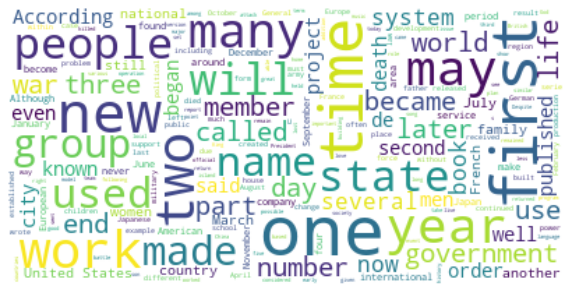

In [25]:
# generate wordcloud for english corpus
wordcloud = WordCloud(max_words=200, max_font_size=50, background_color='white')
wordcloud = wordcloud.generate(english_corpus)

plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')

plt.show()

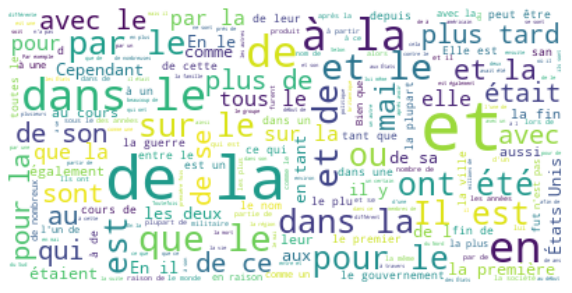

In [26]:
# and for French
wordcloud = WordCloud(max_words=200, max_font_size=50, background_color='white')
wordcloud = wordcloud.generate(french_corpus)

plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')

plt.show()

Although, I didn't get as much information as I though I would from the wordcloud, it was observed that these datasets contained rich, everyday use words that would help much in generalizing for translation of everyday terms

In [27]:
del wordcloud

gc.collect()

6359

### Distribution of word count

Text(0.5, 1.0, 'Word Frequency Distribution in French dataset')

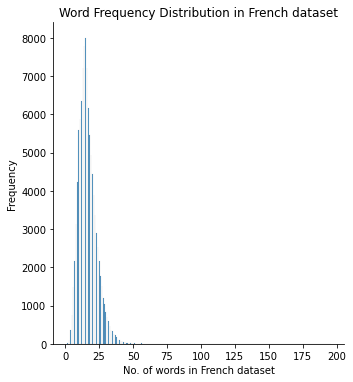

In [28]:
# let's count the number of words in the dataset and see the distribution

fr_text_size = list(map(lambda x: len(x.split()), french_dataset))
sns.displot(fr_text_size)
plt.xlabel('No. of words in French dataset')
plt.ylabel('Frequency')
plt.title('Word Frequency Distribution in French dataset')

Text(0.5, 1.0, 'Word Frequency Distribution in English dataset')

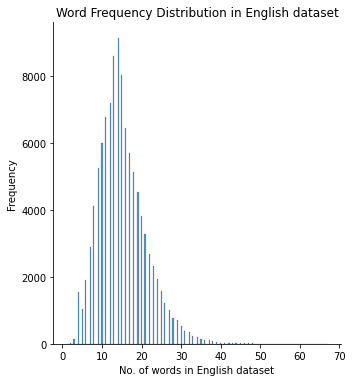

In [29]:
eng_text_size = list(map(lambda x: len(x.split()), english_dataset))
sns.displot(eng_text_size)
plt.xlabel('No. of words in English dataset')
plt.ylabel('Frequency')
plt.title('Word Frequency Distribution in English dataset')

In [30]:
english_textsize = pd.Series(eng_text_size)
french_textsize = pd.Series(fr_text_size)

eng_mean = english_textsize.mean()
french_mean = french_textsize.mean()

print(f"For English, the average word count per entry is: {eng_mean}")
print(f"For French, the average word count per entry is: {french_mean}")

For English, the average word count per entry is: 15.150562644192288
For French, the average word count per entry is: 16.535204105654692


In [31]:
eng_max = english_textsize.max()
french_max = french_textsize.max()

print(f"For English, the max word count per entry is: {eng_max}")
print(f"For French, the max word count per entry is: {french_max}")

For English, the max word count per entry is: 67
For French, the max word count per entry is: 196


We can see that on average, French uses more words for its sentences than English does.

## Tokenization

We need to add START and END tokens to our texts for the encoder and decoder in the transformer.

In [32]:
for i in range(len(english_dataset)):
    english_dataset[i] = "sos " + english_dataset[i] + " eos."
    french_dataset[i] = "sos " + french_dataset[i] + " eos."

In [33]:
for i in range(10):
    print(f"English: {english_dataset[i]}")
    print(f"French: {french_dataset[i]}")
    print("")

English: sos You thought to this day that there were tyrants? eos.
French: sos Vous avez cru jusqu'à ce jour qu'il y avait des tyrans ? eos.

English: sos How do you feed your family?" eos.
French: sos Comment nourrissez-vous votre famille ?" eos.

English: sos The first group shows God creating the Heavens and the Earth. eos.
French: sos Le premier ciel est une voûte à laquelle la terre est fixée par ses extrémités. eos.

English: sos It is said after this he split to a thousand pieces, and became the stars. eos.
French: sos Il est dit après cela, qu'il s'est divisé en mille morceaux, et est devenu les étoiles. eos.

English: sos They are subservient to him, and created for a purely practical end. eos.
French: sos Ils sont serviles à son égard, et créés pour une fin purement pratique. eos.

English: sos It is not Allah’s Glory that He should take (to Himself anyone as) a son. eos.
French: sos Il ne convient pas à Allah de S'attribuer un fils. eos.

English: sos Well, we're about to be

We'll have two tokenizers for this task. One will handle the English dataset while the other will handle the French dataset. The tokenizer used here is the [one here at TensorFlow](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer). After tokenizing, we'll pad the sequences to the same shape with the pad_sequences utility provided on TensorFlow. Because of the behavior of the TensorFlow's Tokenizer and pad_sequences - they expect a list of sequences(lists) - we have to be careful at the evaluating stage where we'll expect to treat one sequence at a time.

Essentially - the Tokenizer class treats ['This is a boy'] on a per-character tokenization scheme since it expects something like ```['This is a boy', 'This is a girl']```.... For a single sequence, doing this - ```[['This is a boy']]``` would yield the intended results.

In [34]:
from tensorflow.keras.preprocessing.text import Tokenizer

num_words = 80000
tokenizer_en = Tokenizer(num_words=num_words, filters='!#$%&()*+,-/:;<=>@«»""[\\]^_`{|}~\t\n')
tokenizer_en.fit_on_texts(english_dataset)

word_index = tokenizer_en.word_index
print(f"The number of words in the English vocabulary: {len(word_index)}")

The number of words in the English vocabulary: 95458


In [35]:
tokenizer_fr = Tokenizer(num_words=num_words, filters='!#$%&()*+,-/:;<=>@«»""[\\]^_`{|}~\t\n')
tokenizer_fr.fit_on_texts(french_dataset)

word_index_fr = tokenizer_fr.word_index
print(f"The number of words in the French vocabulary: {len(word_index_fr)}")

The number of words in the French vocabulary: 122962


In [36]:
english_data = tokenizer_en.texts_to_sequences(english_dataset)
french_data = tokenizer_fr.texts_to_sequences(french_dataset)

In [37]:
len(english_data), len(french_data)

(106195, 106195)

## Padding

The standard practice in NLP is to set each sequence to the same shape so that the neural network receives same shape of input. Now, each sentence in the dataset have varying lengths so we use Keras' pad_sequences function to add 0s to each sequence to the same shape. Just like the Tokenizer above, the pad_sequences expect a list of sequences (basically going to be a list of lists after tokenization).

The documentation for the pad_sequences function is here at [the TensorFlow documentation page](https://www.tensorflow.org/api_docs/python/tf/keras/utils/pad_sequences).

From the statistical work done on the data, we learned that the sentences in the datasets have about an average length of 16-20. I'd pad according to the max from each corpus

In [38]:
from tensorflow.keras.preprocessing.sequence import pad_sequences


# padding according to max length found in dataset
english_data = pad_sequences(english_data, maxlen = 25, padding='post', truncating='post')
french_data = pad_sequences(french_data, maxlen=30, padding='post', truncating='post')

In [39]:
english_data.shape, french_data.shape

((106195, 25), (106195, 30))

In [40]:
# let's see that everything works as intended

test_en = tokenizer_en.sequences_to_texts(english_data[:5])
test_en

['sos you thought to this day that there were tyrants? eos.',
 'sos how do you feed your family? eos.',
 'sos the first group shows god creating the heavens and the earth. eos.',
 'sos it is said after this he split to a thousand pieces and became the stars. eos.',
 'sos they are subservient to him and created for a purely practical end. eos.']

In [41]:
# let's see that everything works as intended

test_fr = tokenizer_fr.sequences_to_texts(french_data[:5])
test_fr

["sos vous avez cru jusqu'à ce jour qu'il y avait des tyrans\xa0? eos.",
 'sos comment nourrissez vous votre famille\xa0? eos.',
 'sos le premier ciel est une voûte à laquelle la terre est fixée par ses extrémités. eos.',
 "sos il est dit après cela qu'il s'est divisé en mille morceaux et est devenu les étoiles. eos.",
 'sos ils sont serviles à son égard et créés pour une fin purement pratique. eos.']

In [42]:
# save the tokenizers for future user

import pickle

# for english
with open('tokenizer_en.pickle', 'wb') as handle:
    pickle.dump(tokenizer_en, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [43]:
# for french
with open('tokenizer_fr.pickle', 'wb') as handle:
    pickle.dump(tokenizer_fr, handle, protocol=pickle.HIGHEST_PROTOCOL)

# 3. Training

## Transformer Hyperparamters, Metrics, Optimizer and Loss

In [44]:
# hyperparameters
d_model = 128
dff = 512
num_layers = 4
num_heads = 8
dropout_rate = 0.1

input_vocab_size = len(tokenizer_fr.word_index) + 2 # french is the input
target_vocab_size = len(tokenizer_en.word_index) + 2 # english is the target

pe_input = input_vocab_size
pe_target = target_vocab_size

EPOCHS = 10
batch_size = 64

Using the adamw optimizer described in [the paper](https://arxiv.org/abs/1706.03762)

$$\Large{lrate = d_{model}^{-0.5} * \min(step{\_}num^{-0.5}, step{\_}num \cdot warmup{\_}steps^{-1.5})}$$

In [45]:
# learning rate
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps = 4000):
        super(CustomSchedule, self).__init__()
        
        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)
        self.warmup_steps = warmup_steps
        
    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)
        
        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)
    
learning_rate = CustomSchedule(d_model)

In [46]:
# First, create the model, optimizer and metrics inside the strategy's scope. 
# This ensures that any variables created with the model and optimizer are mirrored variables.


transformer = Transformer(num_layers, d_model, num_heads, dff, input_vocab_size, target_vocab_size, pe_input, pe_target, dropout_rate)
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2 = 0.98, epsilon = 1e-9)
    
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
    
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)
        
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
        
    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)
    
def accuracy_function(real, pred):
    accuracies = tf.equal(real, tf.argmax(pred, axis=2))
    mask = tf.math.logical_not(tf.math.equal(real, 0))
        
    accuracies = tf.math.logical_and(mask, accuracies)
    accuracies = tf.cast(accuracies, dtype=tf.float32)
    mask = tf.cast(mask, dtype=tf.float32)
        
    return tf.reduce_sum(accuracies)/tf.reduce_sum(mask)
    
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

In [47]:
# checkpointing
checkpoint_path = './train'
    
ckpt = tf.train.Checkpoint(transformer=transformer, optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=3)
    
# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')

In [48]:
# the train function
train_step_signature = [
    tf.TensorSpec(shape=(batch_size, 30), dtype=tf.int64),
    tf.TensorSpec(shape=(batch_size,25), dtype=tf.int64),
]


@tf.function(input_signature = train_step_signature)    
def train_step(inp, tar):
    tar_inp = tar[:, :-1]
    tar_real = tar[:, 1:]
        
    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)
        
    with tf.GradientTape() as tape:
        predictions, _ = transformer(inp, tar_inp, True, enc_padding_mask, combined_mask, dec_padding_mask)
        loss = loss_function(tar_real, predictions)
            
    gradients = tape.gradient(loss, transformer.trainable_variables)
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))
        
    train_loss(loss)
    train_accuracy(tar_real, predictions)

In [49]:
import time

for epoch in range(EPOCHS):
    start = time.time()
    
    train_loss.reset_states()
    train_accuracy.reset_states()
    start_pt = 0
    
    # inp -> french, tar -> english
    for i in range(int(len(english_data)/batch_size)):
        inp = tf.convert_to_tensor(np.array(french_data[start_pt:start_pt+batch_size]),dtype=tf.int64)
        tar = tf.convert_to_tensor(np.array(english_data[start_pt:start_pt+batch_size]),dtype=tf.int64)
        
        start_pt = start_pt + batch_size
        train_step(inp, tar)
        
        if i % 100 == 0:
            print ('Epoch {} Batch {} Loss {:.4f} Accuracy {:.4f}'.format(epoch + 1, i, train_loss.result(), train_accuracy.result()))
    
    if (epoch + 1) % 5 == 0:
        ckpt_save_path = ckpt_manager.save()
        print ('Saving checkpoint for epoch {} at {}'.format(epoch+1, ckpt_save_path))
        
    print ('Epoch {} Loss {:.4f} Accuracy {:.4f}'.format(epoch + 1, train_loss.result(), train_accuracy.result()))
    print ('Total time taken for that epoch: {} secs\n'.format(time.time() - start))

2023-01-07 22:18:53.643169: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1 Batch 0 Loss 11.4746 Accuracy 0.0000
Epoch 1 Batch 100 Loss 11.3709 Accuracy 0.0243
Epoch 1 Batch 200 Loss 11.0937 Accuracy 0.0323
Epoch 1 Batch 300 Loss 10.6726 Accuracy 0.0347
Epoch 1 Batch 400 Loss 10.1702 Accuracy 0.0367
Epoch 1 Batch 500 Loss 9.6846 Accuracy 0.0412
Epoch 1 Batch 600 Loss 9.3132 Accuracy 0.0460
Epoch 1 Batch 700 Loss 9.0275 Accuracy 0.0511
Epoch 1 Batch 800 Loss 8.7913 Accuracy 0.0563
Epoch 1 Batch 900 Loss 8.5952 Accuracy 0.0611
Epoch 1 Batch 1000 Loss 8.4310 Accuracy 0.0656
Epoch 1 Batch 1200 Loss 8.1545 Accuracy 0.0755
Epoch 1 Batch 1300 Loss 8.0087 Accuracy 0.0809
Epoch 1 Batch 1400 Loss 7.8742 Accuracy 0.0865
Epoch 1 Batch 1500 Loss 7.7492 Accuracy 0.0922
Epoch 1 Batch 1600 Loss 7.5749 Accuracy 0.1005
Epoch 1 Loss 7.3540 Accuracy 0.1118
Total time taken for that epoch: 399.17993092536926 secs

Epoch 2 Batch 0 Loss 7.7764 Accuracy 0.0645
Epoch 2 Batch 100 Loss 5.9918 Accuracy 0.1476
Epoch 2 Batch 200 Loss 5.8441 Accuracy 0.1636
Epoch 2 Batch 300 Loss 5.

# 4. Evaluation

In [50]:
maxlen = 25

def evaluate(sentence):
    sentence = 'sos ' + sentence[0] + ' eos.'
    sentence = [sentence] # done because of the way TensorFlow's tokenizer
    
    # vectorize and pad the sentence
    sentence = tokenizer_fr.texts_to_sequences(sentence)
    sentence = pad_sequences(sentence, maxlen=30, padding='post', truncating='post')
    inp = tf.convert_to_tensor(np.array(sentence),dtype=tf.int64) # convert input to tensors
    
    # tokenize the start of the decoder input & convert to tensor
    decoder_input = tokenizer_en.texts_to_sequences(['sos'])
    decoder_input = tf.convert_to_tensor(np.array(decoder_input), dtype=tf.int64)
    
    for i in range(maxlen):
        enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, decoder_input)
        predictions, _ = transformer(inp, decoder_input,False,enc_padding_mask,combined_mask, dec_padding_mask)
        
        # select the last word from the seq_len dimension
        predictions = predictions[: ,-1:, :] 
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int64)
        
        # return the result if the predicted_id is equal to the end token
        if predicted_id == tokenizer_en.texts_to_sequences(['eos']):
            return tf.squeeze(decoder_input, axis=0)
        
        # concatentate the predicted_id to the output which is given to the decoder
        # as its input.
        decoder_input = tf.concat([decoder_input, predicted_id], axis=1)
    return tf.squeeze(decoder_input, axis=0)
        

In [51]:
def translate(sentence):
    sentence = [sentence] # our evaluate function requires lists
    print('Input: {}'.format(sentence[0]))
    print("Please wait while we translate: \n")
    result = (evaluate(sentence)).tolist()
    
    predicted_sentence = tokenizer_en.sequences_to_texts([[i for i in result if i != tokenizer_en.texts_to_sequences(['sos'])[0][0]
                                                          and i != tokenizer_en.texts_to_sequences(['eos.'])[0][0]]])  

    
    print('Predicted translation: {}'.format(predicted_sentence[0]))

In [52]:
sentence = "Je vous aime."
translate(sentence)

Input: Je vous aime.
Please wait while we translate: 

Predicted translation: i dislike your


In [53]:
sentence = "J'adore manger des bananes."
translate(sentence)

Input: J'adore manger des bananes.
Please wait while we translate: 

Predicted translation: i love to eat


In [54]:
sentence = "C'est un triste jour dans le New Jersey."
translate(sentence)

Input: C'est un triste jour dans le New Jersey.
Please wait while we translate: 

Predicted translation: it is a sad day in new jersey.


In [55]:
sentence = "J'ai eu une très belle conversation avec toi."
translate(sentence)

Input: J'ai eu une très belle conversation avec toi.
Please wait while we translate: 

Predicted translation: i have a beautiful conversation with you.


In [56]:
sentence = "Le professeur ne m'aime pas."
translate(sentence)

Input: Le professeur ne m'aime pas.
Please wait while we translate: 

Predicted translation: professor is not. is not.


In [57]:
sentence = "L'entreprise a fait faillite."
translate(sentence)

Input: L'entreprise a fait faillite.
Please wait while we translate: 

Predicted translation: the company went mango


In [58]:
sentence = "Le médecin ordonne à Daniel de regarder le film."
translate(sentence)

Input: Le médecin ordonne à Daniel de regarder le film.
Please wait while we translate: 

Predicted translation: the doctor ordered daniel to watch the film.


In [59]:
sentence = "Ce n'est pas très spécial."
translate(sentence)

Input: Ce n'est pas très spécial.
Please wait while we translate: 

Predicted translation: it is not very special is not highly special


In [60]:
sentence = "Albert est né chrétien mais devient musulman."
translate(sentence)

Input: Albert est né chrétien mais devient musulman.
Please wait while we translate: 

Predicted translation: albert is born christian but it is becoming a muslim


In [61]:
sentence = "Je suis né le 3 décembre."
translate(sentence)

Input: Je suis né le 3 décembre.
Please wait while we translate: 

Predicted translation: i am born on 3 december.


In [65]:
sentence = "C'est la fin de la première phase."
translate(sentence)

Input: C'est la fin de la première phase.
Please wait while we translate: 

Predicted translation: it is the end of the first phase. phase.


## 5. Exporting the model

In [62]:
transformer.save_weights("exports/french_translator")

In [63]:
model = Transformer(num_layers, d_model, num_heads, dff, input_vocab_size, target_vocab_size, pe_input, pe_target, dropout_rate)

In [64]:
model.load_weights("exports/french_translator")

## Resources

Heavy inspiration - 

On Understanding how the architecture works
* https://jalammar.github.io/illustrated-transformer/
* https://e2eml.school/transformers.html
* https://theaisummer.com/skip-connections/#u-nets-long-skip-connections
* https://theaisummer.com/transformer/

On Implementation
* https://www.tensorflow.org/text/tutorials/transformer

* https://colab.research.google.com/github/dlmacedo/starter-academic/blob/master/content/courses/deeplearning/notebooks/tensorflow/transformer.ipynb#scrollTo=s_qNSzzyaCbD

* https://colab.research.google.com/drive/1CBe2VlogbyXzmIyRQGH5xzuvLwGrvjcf?usp=sharing#scrollTo=y7TFAAnXklib

* https://sungwookyoo.github.io/study/Transformer/
* https://colab.research.google.com/github/tensorflow/text/blob/master/docs/tutorials/transformer.ipynb#scrollTo=iYQdOO1axwEI